# DNN Model(Binary) for MIT data 
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: MinMax Scaler

If you don't have the original files: run the notebook `preprocessing_mit_minmax_oversampling.ipynb`     
Input file: (The preprocessed data)   
mitbih_train_clean_minmax_oversampling.csv   
mitbih_test_clean_minmax_oversampling.csv

Output: DNN model trained  
model_mit_dnn.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_test_clean_minmax_oversampling.csv'  
})


OutputFiles = dict({
    'model': model_output_path +  'model_mit_dnn.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
X_train.shape[1]

187

# DNN with MinMax Scaler and Oversampling

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import random

# Seed 
seed = 42
np.random.seed(seed) # Seed for NumPy
tf.random.set_seed(seed) # Seed for TensorFlow
random.seed(seed) # Seed for Python

# Modell
model = Sequential()

# Input layer
model.add(Dense(187, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization()) # Batch Normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

# 2. Layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4)) # Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.
# In combination with Batch Normalization, Dropout can help to avoid overfitting.

# 3. Layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 4. Layer
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer
model.add(Dense(1, activation='sigmoid')) # Sigmoid activation function is used for binary classification problems.

# Compile
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001) # Adamax is a variant of Adam based on the infinity norm. It is robust and performs well in practice.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC']) # Binary Crossentropy is used for binary classification problems. AUC is the Area Under the ROC Curve.

model.summary()

# Callbacks: EarlyStopping 
early_stopping = EarlyStopping(
    monitor='val_loss',   # value that will be monitored  
    min_delta=0.01,       # minimium amount of change to count as an improvement    
    patience=10,          # how many epochs to wait before stopping    
    verbose=1,            # print additional information like the epoch number
    mode='min',           # direction of improvement to stop training
    restore_best_weights=True # restore the best weights when stopping
)

# ReduceLROnPlateau
reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",  # value that will be monitored     
    min_delta=0.01,      # minimium amount of change to count as an improvement     
    patience=3,          # how many epochs to wait before stopping     
    factor=0.1,          # factor by which the learning rate will be reduced   
    cooldown=4,          # number of epochs to wait before resuming normal operation after lr has been reduced     
    verbose=1            # print additional information like the epoch number     
)

# Train Modell
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_learning_rate],
    verbose=1
)

# Train Scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

print(f"Final Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
      f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

# Prediction
y_pred = model.predict(X_test)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")
y_pred_class = (y_pred >= optimal_threshold).astype(int)

# Evaluation Test
from sklearn.metrics import confusion_matrix, classification_report, f1_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 187)            │           748 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,705 (198.07 KB)

 Trainable params: 50,123 (195.79 KB)

 Non-trainable params: 582 (2.27 KB)

Epoch 1/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - AUC: 0.8088 - accuracy: 0.7484 - loss: 0.5362 - val_AUC: 0.9669 - val_accuracy: 0.9585 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 2/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9438 - accuracy: 0.8973 - loss: 0.2857 - val_AUC: 0.9710 - val_accuracy: 0.9486 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 3/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9575 - accuracy: 0.9148 - loss: 0.2465 - val_AUC: 0.9748 - val_accuracy: 0.9584 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 4/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9674 - accuracy: 0.9246 - loss: 0.2171 - val_AUC: 0.9786 - val_accuracy: 0.9668 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 5/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9741 - accuracy: 0.9331 - loss: 0.1948 - val_AUC: 0.9795 - val_accuracy: 0.9665 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 6/100
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - AUC: 0.9

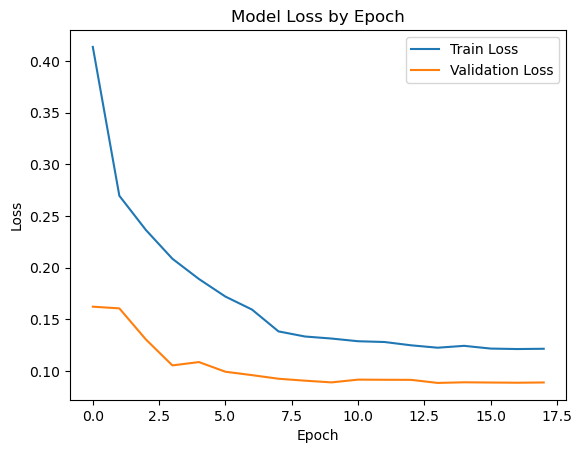

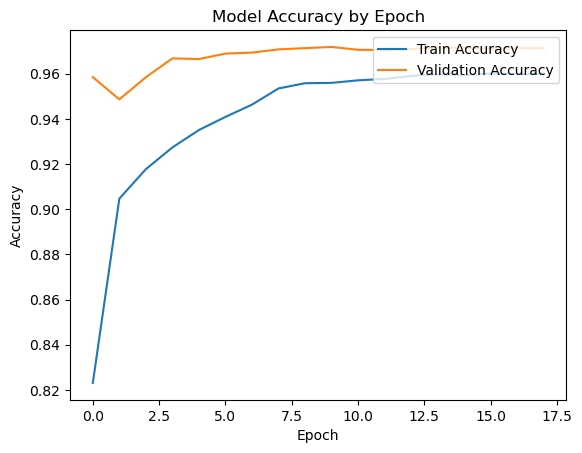

634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
Confusion Matrix:
 [[17684   434]
 [  159  2007]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     18118
           1       0.82      0.93      0.87      2166

    accuracy                           0.97     20284
   macro avg       0.91      0.95      0.93     20284
weighted avg       0.97      0.97      0.97     20284

F1 Score: 0.8713


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Plotting the Loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class):.4f}")

# Save DNN Model

In [35]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(model, model_file)

In [36]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-08 16:14:15.095585
